In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pybaseball as pb
import math
import plotly.express as px
import datetime as dt

sns.set_style("darkgrid")
pd.set_option("display.max_columns", None)

In [2]:
def get_season_data():
    """
    queries 2022 statcast data week-by-week from opening day up to current date to handle api limits.
    """
    weeks = []
    start = dt.date(2022, 4, 7)
    today = dt.date.today()
    days = (today-start).days
    num_weeks = (days // 7) + 1
    counter = 0
    for d in range(days):
        if d%7 == 0:
            end = start + dt.timedelta(days=7)
            week = pb.statcast(start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))
            weeks.append(week)
            counter+=1
            print("week {}/{} complete".format(counter, num_weeks))
            start = end
            
        elif (d+1) == days:
            end = start + dt.timedelta(days=(d%7))
            week = pb.statcast(start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"))
            counter+=1
            print("week {}/{} complete".format(counter, num_weeks))
            
        
    return pd.concat(weeks)

In [3]:
df = get_season_data()
df = df.drop_duplicates()

This is a large query, it may take a moment to complete


100%|██████████| 8/8 [00:12<00:00,  1.60s/it]

week 1/12 complete
This is a large query, it may take a moment to complete



100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


week 2/12 complete
This is a large query, it may take a moment to complete


100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


week 3/12 complete
This is a large query, it may take a moment to complete


100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


week 4/12 complete
This is a large query, it may take a moment to complete


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]

week 5/12 complete
This is a large query, it may take a moment to complete



100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


week 6/12 complete
This is a large query, it may take a moment to complete


100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


week 7/12 complete
This is a large query, it may take a moment to complete


100%|██████████| 8/8 [00:08<00:00,  1.01s/it]

week 8/12 complete
This is a large query, it may take a moment to complete



100%|██████████| 8/8 [00:08<00:00,  1.05s/it]

week 9/12 complete
This is a large query, it may take a moment to complete



100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


week 10/12 complete
This is a large query, it may take a moment to complete


100%|██████████| 8/8 [00:14<00:00,  1.80s/it]

week 11/12 complete
This is a large query, it may take a moment to complete



100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


week 12/12 complete
This is a large query, it may take a moment to complete


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


week 13/12 complete


# Creating a batter name column from mlbam ids

In [4]:
names = pb.playerid_reverse_lookup(df['batter'])
names['batter_name'] = names['name_first'] + " " + names['name_last']
names = names[['key_mlbam', 'batter_name']]

In [5]:
df = pd.merge(df, names, how='left', left_on='batter', right_on='key_mlbam')

In [6]:
df['batter_name']

0         brendan rodgers
1         brendan rodgers
2         brendan rodgers
3         brendan rodgers
4         brendan rodgers
               ...       
321995    freddie freeman
321996    freddie freeman
321997    freddie freeman
321998        trea turner
321999        trea turner
Name: batter_name, Length: 322000, dtype: object

In [7]:
len(df)

322000

In [8]:
df['woba_denom'].describe()

count    82305.000000
mean         0.996452
std          0.059458
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: woba_denom, dtype: float64

# Subsetting for batted ball events with non-null variables of interest

In [9]:
bbe = df.loc[df['description'] == 'hit_into_play',]
bbe = bbe.dropna(subset=['launch_speed', 'launch_angle', 'hc_x', 'hc_y'])

In [10]:
len(bbe)

56202

<AxesSubplot:>

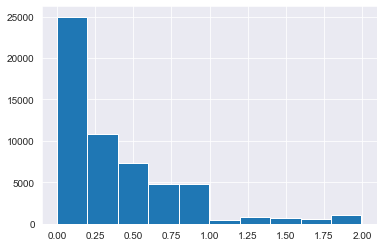

In [11]:
bbe['estimated_woba_using_speedangle'].hist()

# training a random forest regression model based on exit velocity and launch angle and using cross-validation to measure performance

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

In [13]:
X = bbe[['launch_speed', 'launch_angle']]
y = bbe['woba_value'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [14]:
model = RandomForestRegressor(
    n_estimators=100,
    min_samples_leaf = 100
)

In [15]:
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=100)

In [16]:
cross_val_score(model, X, y, cv=5)

/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is depre

array([0.39831355, 0.40184786, 0.42813028, 0.43499646, 0.42812686])

In [17]:
y_pred = model.predict(X)
bbe['rf_xwoba'] = y_pred

# grouping events by batter to get mean xwobacon for each player

In [18]:
xwobacon_leaders = bbe.groupby('batter_name')['rf_xwoba'].agg(['mean', 'count'])

In [19]:
xwobacon_leaders.sort_values(by='count', ascending=False)

,mean,count
batter_name,,
whit merrifield,0.328937,257
cesar hernandez,0.334155,249
adam frazier,0.310127,242
cedric mullins,0.331013,236
alex verdugo,0.363231,236
...,...,...
ka'ai tom,0.031749,1
dj stewart,0.053415,1
liover peguero,0.459748,1


In [20]:
df.events.unique()

array(['strikeout', None, 'field_out', 'single', 'force_out',
       'grounded_into_double_play', 'walk', 'double', 'home_run',
       'double_play', 'field_error', 'fielders_choice', 'hit_by_pitch',
       'triple', 'sac_fly', 'fielders_choice_out', 'catcher_interf',
       'sac_bunt', 'pickoff_2b', 'caught_stealing_2b', 'other_out',
       'strikeout_double_play', 'triple_play', 'caught_stealing_3b',
       'pickoff_1b', 'wild_pitch', 'sac_fly_double_play',
       'caught_stealing_home', 'game_advisory', 'pickoff_3b'],
      dtype=object)

In [21]:
df.loc[df['launch_speed'].isna() & df['woba_denom']!=0].events.unique()

array(['strikeout', 'walk', 'hit_by_pitch', 'catcher_interf',
       'strikeout_double_play'], dtype=object)

# Counting all woba events (bbe, strikeouts, hbp, and BB) to count up total plate appearances

In [22]:
num_pa = df.groupby('batter_name')['woba_value'].agg(['mean', 'count'])

In [23]:
num_pa.nlargest(10, 'count')

,mean,count
batter_name,,
cesar hernandez,0.297006,334
jake cronenworth,0.339091,330
tommy edman,0.335321,327
whit merrifield,0.265846,325
bo bichette,0.326852,324
jurickson profar,0.342747,324
matt olson,0.353858,324
francisco lindor,0.343189,323
juan soto,0.367183,323


In [24]:
df['woba_value'].count()

82585

In [25]:
xwobacon_leaders[xwobacon_leaders.index == 'pete alonso']

,mean,count
batter_name,,
pete alonso,0.448947,213


In [26]:
xwobacon_leaders[xwobacon_leaders.index == 'rafael devers']

,mean,count
batter_name,,
rafael devers,0.462197,235


In [27]:
xwobacon_leaders[xwobacon_leaders.index == 'mike trout']

,mean,count
batter_name,,
mike trout,0.548302,159


# calculating xwoba from bbe xwobacon and non-bbe woba

In [28]:
xwobacon_leaders['non_bbe'] = num_pa['mean']
xwobacon_leaders['non_bbe_count'] = num_pa['count'].sub(xwobacon_leaders['count'])
xwobacon_leaders['total'] = num_pa['count']

xwobacon_leaders['xwoba'] = ((xwobacon_leaders['mean']*xwobacon_leaders['count']) + \
                            (xwobacon_leaders['non_bbe']*xwobacon_leaders['non_bbe_count'])) / \
                            xwobacon_leaders['total']

In [29]:
xwobacon_leaders.nlargest(25, "total")

,mean,count,non_bbe,non_bbe_count,total,xwoba
batter_name,,,,,,
cesar hernandez,0.334155,249,0.297006,85.0,334,0.324701
jake cronenworth,0.328788,220,0.339091,110.0,330,0.332222
tommy edman,0.347035,233,0.335321,94.0,327,0.343668
whit merrifield,0.328937,257,0.265846,68.0,325,0.315736
bo bichette,0.420067,222,0.326852,102.0,324,0.390721
jurickson profar,0.340564,228,0.342747,96.0,324,0.341211
matt olson,0.415661,211,0.353858,113.0,324,0.394106
francisco lindor,0.358323,226,0.343189,97.0,323,0.353778
juan soto,0.408315,212,0.367183,111.0,323,0.39418


# transforming hit coordinates over 1st quadrant of xy-plane for ease in calculating spray angle

In [30]:
bbe['hc_x_adj'] = bbe['hc_x'].sub(126)
bbe['hc_y_adj'] = 204.5 - bbe['hc_y']
rad = -math.pi/4
rotation_mat = np.array([[math.cos(rad), math.sin(rad)],
                         [-math.sin(rad), math.cos(rad)]])
bbe[['field_x', 'field_y']] = bbe[['hc_x_adj', 'hc_y_adj']].dot(rotation_mat).astype(np.float64)

In [31]:
bbe_plot = bbe.dropna(subset=['field_x', 'field_y', 'woba_value'])

In [32]:
bbe_plot['woba_value'].value_counts()

0.00    37625
0.90    12339
1.25     3601
2.00     2331
1.60      306
Name: woba_value, dtype: Int64

Text(0.5, 1.0, 'Random forest xwOBA estimates (no spray angle)')

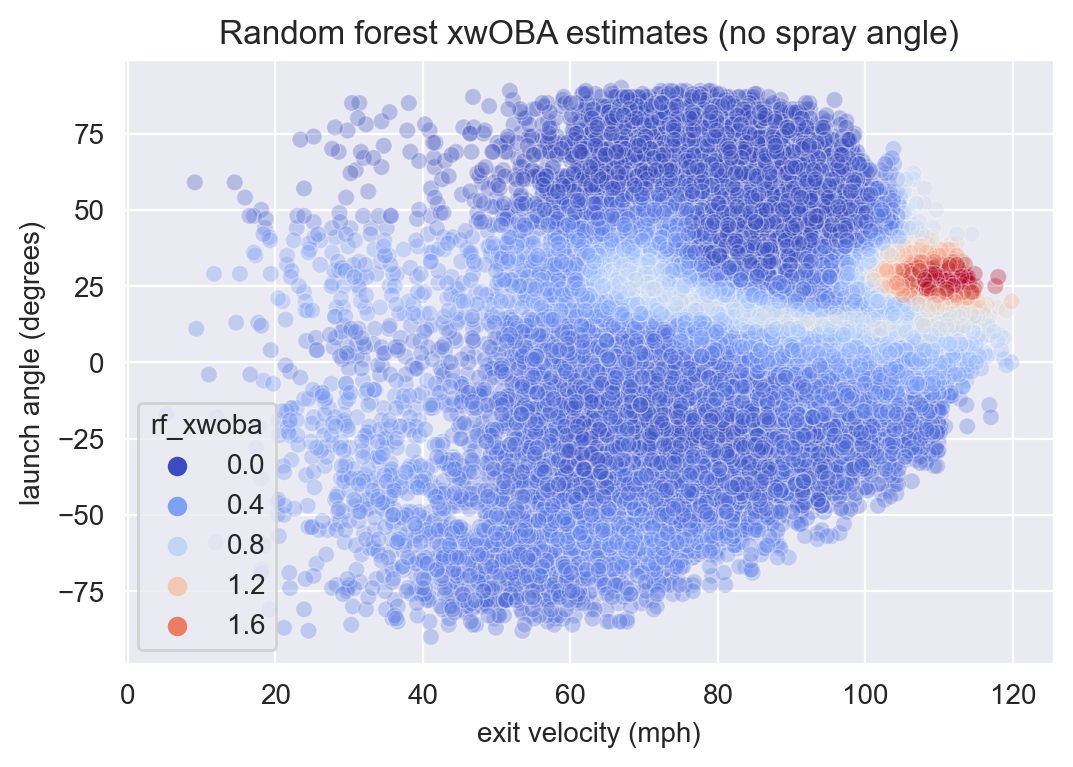

In [33]:
fig, ax = plt.subplots(dpi=200)
ax = sns.scatterplot(x='launch_speed', 
           y='launch_angle',
           hue='rf_xwoba',
           palette='coolwarm',
           alpha=0.3,
           data=bbe)
ax.set_xlabel("exit velocity (mph)")
ax.set_ylabel("launch angle (degrees)")
ax.set_title("Random forest xwOBA estimates (no spray angle)")


# calculating spray angle (theta_deg) from inverse tangent function of transformed hit coordinates

In [34]:
bbe['field_x'] = bbe['field_x'].astype(float)
bbe['field_y'] = bbe['field_y'].astype(float)
bbe['theta'] = np.arctan(bbe['field_y'].div(bbe['field_x']))
bbe['theta_deg'] = bbe['theta'].mul(180/math.pi)

<AxesSubplot:>

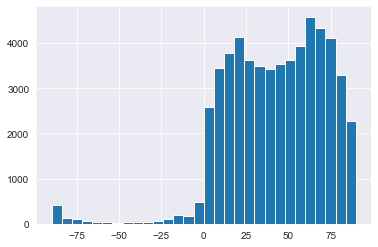

In [35]:
bbe['theta_deg'].hist(bins=30)

# visualizing distribution of home runs by spray angle

In [36]:
homers = bbe.loc[bbe['events'] == 'home_run']

<AxesSubplot:>

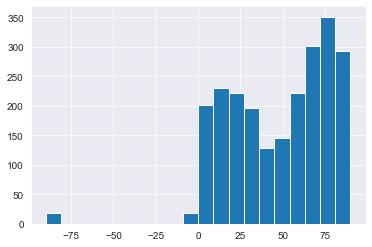

In [37]:
homers['theta_deg'].hist(bins=20)

# incorporating spray angle into random forest model

In [38]:
bbe_spray = bbe.dropna(subset=['launch_speed', 'launch_angle', 'woba_value'])
bbe_spray = bbe_spray.fillna(0)

In [39]:
X_spray = bbe_spray[['launch_speed', 'launch_angle', 'theta_deg']]
y_spray = bbe_spray['woba_value'].values

In [40]:
X_spray.isna().sum()

launch_speed    0
launch_angle    0
theta_deg       0
dtype: int64

In [41]:
cross_val_score(model, X_spray, y_spray, cv=5)

/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/opt/anaconda3/envs/datasci/lib/python3.9/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is depre

array([0.474134  , 0.46772374, 0.49673013, 0.49964112, 0.49891084])

In [42]:
model.fit(X_spray, y_spray)

RandomForestRegressor(min_samples_leaf=100)

In [43]:
y_pred_spray = model.predict(X_spray)

In [44]:
len(y_pred_spray)

56202

In [45]:
len(bbe)

56202

In [46]:
bbe['rf_spray_xwoba'] = y_pred_spray

In [47]:
len(y_pred_spray)

56202

# generating spray xwoba leaderboards

In [48]:
spray_xwobacon = bbe.groupby('batter_name')['rf_spray_xwoba'].agg(['mean', 'count'])

In [49]:
spray_xwobacon.sort_values('count', ascending=False)

,mean,count
batter_name,,
whit merrifield,0.311668,257
cesar hernandez,0.340733,249
adam frazier,0.305702,242
cedric mullins,0.329863,236
alex verdugo,0.359785,236
...,...,...
ka'ai tom,0.030315,1
dj stewart,0.086634,1
liover peguero,0.549755,1


In [50]:
bbe['rf_spray_xwoba'].describe()

count    56202.000000
mean         0.369181
std          0.384393
min          0.000043
25%          0.084136
50%          0.231760
75%          0.566878
max          1.982297
Name: rf_spray_xwoba, dtype: float64

In [51]:
xwobacon_leaders['spray_xwoba'] = spray_xwobacon['mean']
xwobacon_leaders['spray_xwoba_count'] = spray_xwobacon['count']
xwobacon_leaders['diff'] = xwobacon_leaders['spray_xwoba'].sub(xwobacon_leaders['xwoba'])

In [52]:
xwobacon_leaders.sort_values('total', ascending=False)

,mean,count,non_bbe,non_bbe_count,total,xwoba,spray_xwoba,spray_xwoba_count,diff
batter_name,,,,,,,,,
cesar hernandez,0.334155,249,0.297006,85.0,334,0.324701,0.340733,249,0.016032
jake cronenworth,0.328788,220,0.339091,110.0,330,0.332222,0.320572,220,-0.01165
tommy edman,0.347035,233,0.335321,94.0,327,0.343668,0.337643,233,-0.006024
whit merrifield,0.328937,257,0.265846,68.0,325,0.315736,0.311668,257,-0.004069
jurickson profar,0.340564,228,0.342747,96.0,324,0.341211,0.348018,228,0.006807
...,...,...,...,...,...,...,...,...,...
khalil lee,0.800626,2,1.0,0.0,2,0.800626,0.791114,2,-0.009512
reiver sanmartin,0.121934,1,0.0,1.0,2,0.060967,0.028731,1,-0.032236
yermin mercedes,0.012637,1,0.0,1.0,2,0.006319,0.008301,1,0.001982


In [53]:
len(bbe)

56202

In [54]:
len(bbe.loc[bbe['batter_name'] == 'joc pederson'])

142

In [55]:
non_bbe = df.loc[(df['woba_denom'] == 1) & (df['launch_speed'].isna())]


In [56]:
non_bbe

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,key_mlbam,batter_name
0,FF,2022-04-14,92.4,-2.73,5.08,"Givens, Mychal",663898,571710,strikeout,swinging_strike,<NA>,<NA>,<NA>,<NA>,1,Brendan Rodgers strikes out swinging.,R,R,R,COL,CHC,S,2,None,2,2,2022,-0.03,0.81,-0.29,3.42,<NA>,<NA>,592178,2,9,Bot,<NA>,<NA>,<NA>,<NA>,543228,<NA>,<NA>,6.307194,-134.660579,-0.28209,-1.563605,24.815642,-22.310743,3.37,1.53,<NA>,<NA>,<NA>,93.5,2513,6.5,662950,571710,543228,643524,663611,621550,663538,664023,542364,673548,54.0,<NA>,<NA>,0.0,1,0,0,<NA>,77,7,4-Seam Fastball,2,5,2,5,5,2,2,5,Standard,Standard,214,-0.014,-0.192,663898,brendan rodgers
13,FF,2022-04-14,93.4,-2.7,4.77,"Givens, Mychal",453568,571710,strikeout,called_strike,<NA>,<NA>,<NA>,<NA>,4,Charlie Blackmon called out on strikes.,R,L,R,COL,CHC,S,2,None,1,2,2022,-0.58,0.86,-0.76,2.43,<NA>,<NA>,<NA>,0,9,Bot,<NA>,<NA>,<NA>,<NA>,543228,<NA>,<NA>,6.276758,-136.122486,-2.313903,-8.425016,22.980737,-21.001384,3.59,1.67,<NA>,<NA>,<NA>,94.4,2492,6.3,662950,571710,543228,643524,663611,621550,663538,664023,542364,673548,54.24,<NA>,<NA>,0.0,1,0,0,<NA>,74,4,4-Seam Fastball,2,5,2,5,5,2,2,5,Infield shift,Standard,231,-0.021,-0.161,453568,charlie blackmon
17,SL,2022-04-14,91.5,-1.0,6.55,"Kinley, Tyler",621550,641755,strikeout,swinging_strike,<NA>,<NA>,<NA>,<NA>,6,Patrick Wisdom strikes out swinging.,R,R,R,COL,CHC,S,2,None,1,2,2022,0.3,0.21,0.71,2.18,<NA>,<NA>,<NA>,2,9,Top,<NA>,<NA>,<NA>,<NA>,553869,<NA>,<NA>,3.62073,-133.371405,-5.665378,2.919941,24.076085,-28.739097,3.47,1.59,<NA>,<NA>,<NA>,91.0,2265,5.5,662950,641755,553869,543068,663898,641857,578428,592178,602074,453568,54.95,<NA>,<NA>,0.0,1,0,0,<NA>,73,5,Slider,2,5,5,2,5,2,5,2,Standard,Standard,183,0.001,-0.071,621550,patrick wisdom
22,SL,2022-04-14,87.9,-1.01,6.48,"Kinley, Tyler",664023,641755,strikeout,swinging_strike,<NA>,<NA>,<NA>,<NA>,7,Ian Happ strikes out swinging.,R,L,R,COL,CHC,S,2,None,1,2,2022,0.28,0.14,-0.56,2.04,<NA>,<NA>,<NA>,1,9,Top,<NA>,<NA>,<NA>,<NA>,553869,<NA>,<NA>,0.511192,-128.189901,-5.012464,3.05691,22.686577,-29.875273,3.37,1.53,<NA>,<NA>,<NA>,87.4,2489,5.5,662950,641755,553869,543068,663898,641857,578428,592178,602074,453568,54.95,<NA>,<NA>,0.0,1,0,0,<NA>,72,5,Slider,2,5,5,2,5,2,5,2,Infield shift,Standard,117,0.003,-0.115,664023,ian happ
29,CU,2022-04-14,82.2,-1.35,5.96,"Thompson, Keegan",656582,624522,strikeout,called_strike,<NA>,<NA>,<NA>,<NA>,7,Connor Joe called out on strikes.,R,R,R,COL,CHC,S,2,None,1,2,2022,0.26,-0.97,-0.53,1.7,<NA>,<NA>,602074,2,8,Bot,<NA>,<NA>,<NA>,<NA>,543228,<NA>,<NA>,1.334527,-119.755551,-1.26703,2.286168,22.999205,-41.488617,3.33,1.66,<NA>,<NA>,<NA>,82.1,2715,6.2,662950,624522,543228,643524,663611,621550,542340,664023,641684,673548,54.34,<NA>,<NA>,0.0,1,0,0,<NA>,70,5,Curveball,2,5,2,5,5,2,2,5,Standard,Standard,40,-0.021,-0.157,656582,connor joe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [57]:
non_bbe.groupby('events')['woba_value'].mean()

events
catcher_interf                0.7
hit_by_pitch                  0.7
strikeout                0.001339
strikeout_double_play         0.0
walk                          0.7
Name: woba_value, dtype: Float64

In [58]:
non_bbe_woba = non_bbe.groupby('batter_name')['woba_value'].agg(['mean', 'count'])
non_bbe_woba.nlargest(10, 'count')

,mean,count
batter_name,,
eugenio suarez,0.19,140
kyle schwarber,0.241727,139
patrick wisdom,0.168,125
rhys hoskins,0.225424,118
chris taylor,0.155556,117
trevor story,0.167521,117
ryan mcmahon,0.223276,116
austin riley,0.176522,115
christian yelich,0.233333,114


In [59]:
xwobacon_leaders['non_bbe_woba'] = non_bbe_woba['mean']
xwobacon_leaders['non_bbe_count'] = non_bbe_woba['count']

In [60]:
xwoba_sum = xwobacon_leaders['mean'].mul(xwobacon_leaders['spray_xwoba_count'])
bbe_sum = xwobacon_leaders['spray_xwoba'].mul(xwobacon_leaders['spray_xwoba_count'])
non_bbe_sum = xwobacon_leaders['non_bbe_woba'].mul(xwobacon_leaders['non_bbe_count'])
total = xwobacon_leaders['non_bbe_count'].add(xwobacon_leaders['spray_xwoba_count'])
spray_xwoba = (bbe_sum + non_bbe_sum) / total
mlb_xwoba = (xwoba_sum + non_bbe_sum) / total


In [61]:
spray_xwoba_leaders = pd.DataFrame.from_dict({
    'xwoba' : mlb_xwoba,
    'spray xwoba': spray_xwoba,
    'pa' : total
})
spray_xwoba_leaders['diff'] = spray_xwoba_leaders['spray xwoba'].sub(spray_xwoba_leaders['xwoba'])
spray_xwoba_leaders.nlargest(20, 'pa')

,xwoba,spray xwoba,pa,diff
batter_name,,,,
cesar hernandez,0.302416,0.307335,333.0,0.004918
jake cronenworth,0.313252,0.307724,327.0,-0.005527
tommy edman,0.319874,0.313141,325.0,-0.006733
whit merrifield,0.307498,0.293842,325.0,-0.013656
matt olson,0.359273,0.362883,324.0,0.00361
bo bichette,0.330915,0.336074,322.0,0.005159
francisco lindor,0.323233,0.325082,322.0,0.00185
juan soto,0.403611,0.398113,322.0,-0.005498
jurickson profar,0.335665,0.34096,321.0,0.005294


spray xwoba leaders among those with over 150 plate appearances

In [62]:
qual = spray_xwoba_leaders.loc[spray_xwoba_leaders['pa'] > 150].round(3)
qual.nlargest(50, 'spray xwoba')

,xwoba,spray xwoba,pa,diff
batter_name,,,,
yordan álvarez,0.466,0.449,265.0,-0.017
aaron judge,0.431,0.437,309.0,0.005
bryce harper,0.424,0.426,270.0,0.002
mike trout,0.409,0.421,273.0,0.012
alejandro kirk,0.413,0.418,234.0,0.005
rafael devers,0.401,0.413,311.0,0.012
giancarlo stanton,0.399,0.408,249.0,0.009
j. d. martinez,0.389,0.403,281.0,0.014
juan soto,0.404,0.398,322.0,-0.005


In [63]:
qual = qual.astype(np.float)

/var/folders/mn/zccfyhzs2q1702wmw5mwrrgr0000gn/T/ipykernel_66933/389028134.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qual = qual.astype(np.float)


0.005
0.005
0.002
-0.022
0.012
-0.028
0.024
-0.021
0.012
-0.017


([<matplotlib.axis.YTick at 0x7f896938ad30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

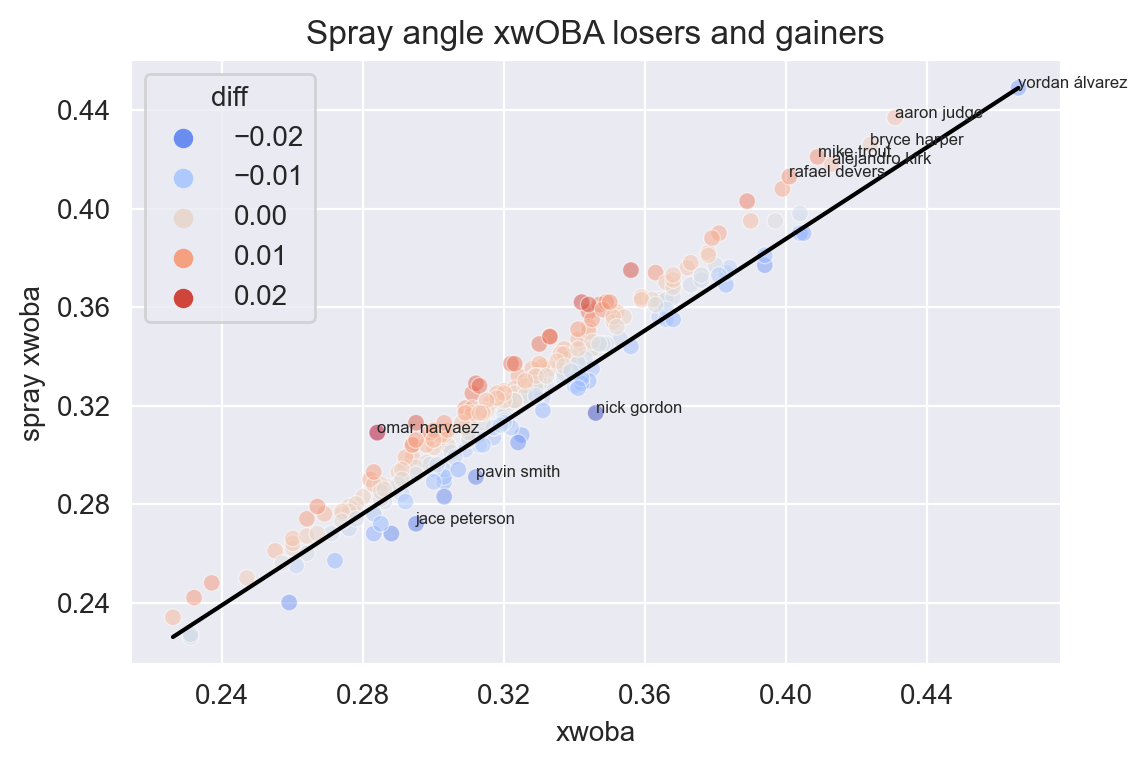

In [64]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(x='xwoba', y='spray xwoba', hue='diff', palette='coolwarm', alpha=0.5, ax=ax, data=qual)
for i in range(len(qual)):
  if (np.abs(qual['diff'][i]) > 0.02) | (qual['spray xwoba'][i] > 0.41):
    print(qual['diff'][i])
    s = qual.index[i]
    x = qual['xwoba'][i]
    y = qual['spray xwoba'][i]
    plt.annotate(s, (x, y), fontsize=6)
ax.set_title("Spray angle xwOBA losers and gainers")
ax.plot([qual['xwoba'].min(),qual['xwoba'].max()], [qual['spray xwoba'].min(), qual['spray xwoba'].max()], c='k')
plt.xticks(np.arange(0.24, 0.48, 0.04))
plt.yticks(np.arange(0.24, 0.48, 0.04))

In [65]:
qual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270 entries, aaron hicks to yuli gurriel
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   xwoba        270 non-null    float64
 1   spray xwoba  270 non-null    float64
 2   pa           270 non-null    float64
 3   diff         270 non-null    float64
dtypes: float64(4)
memory usage: 10.5+ KB


In [66]:
qual['spray xwoba'].mean(), qual['xwoba'].mean()

(0.3234851851851852, 0.323437037037037)

|batter\_name|xwoba|spray xwoba|pa|diff|
|---|---|---|---|---|
|yordan álvarez|0\.465|0\.447|249\.0|-0\.018|
|aaron judge|0\.44|0\.443|282\.0|0\.002|
|bryce harper|0\.428|0\.432|256\.0|0\.004|
|mike trout|0\.409|0\.421|260\.0|0\.012|
|rafael devers|0\.397|0\.41|293\.0|0\.013|
|alejandro kirk|0\.394|0\.404|213\.0|0\.01|
|giancarlo stanton|0\.397|0\.404|223\.0|0\.007|
|j\. d. martinez|0\.384|0\.398|257\.0|0\.014|
|ronald acuna|0\.384|0\.398|183\.0|0\.014|
|juan soto|0\.399|0\.395|302\.0|-0\.005|
|pete alonso|0\.383|0\.393|292\.0|0\.01|
|joc pederson|0\.407|0\.391|191\.0|-0\.015|
|willson contreras|0\.39|0\.391|251\.0|0\.001|
|freddie freeman|0\.388|0\.389|292\.0|0\.0|
|trey mancini|0\.376|0\.384|260\.0|0\.007|
|kyle tucker|0\.393|0\.383|249\.0|-0\.009|
|austin riley|0\.377|0\.382|297\.0|0\.005|
|josé abreu|0\.397|0\.381|282\.0|-0\.016|
|byron buxton|0\.367|0\.379|218\.0|0\.012|
|christian walker|0\.377|0\.379|272\.0|0\.002|
|taylor ward|0\.387|0\.379|196\.0|-0\.008|
|tim anderson|0\.366|0\.379|181\.0|0\.013|
|ty france|0\.371|0\.378|301\.0|0\.006|
|paul goldschmidt|0\.374|0\.377|290\.0|0\.004|
|vladimir guerrero|0\.38|0\.376|282\.0|-0\.004|
|corey seager|0\.375|0\.375|283\.0|0\.0|
|kyle schwarber|0\.386|0\.375|291\.0|-0\.011|
|j\. d. davis|0\.381|0\.374|158\.0|-0\.006|
|luis arraez|0\.366|0\.373|238\.0|0\.006|
|mike yastrzemski|0\.36|0\.372|230\.0|0\.012|
|michael brantley|0\.39|0\.371|252\.0|-0\.019|
|shohei ohtani|0\.376|0\.37|289\.0|-0\.006|
|max kepler|0\.372|0\.369|235\.0|-0\.003|
|jose ramirez|0\.357|0\.368|262\.0|0\.011|
|matt olson|0\.363|0\.368|303\.0|0\.005|
|josh donaldson|0\.344|0\.367|214\.0|0\.023|
|ryan mountcastle|0\.375|0\.367|238\.0|-0\.008|
|garrett cooper|0\.357|0\.364|237\.0|0\.007|
|ji-man choi|0\.363|0\.364|180\.0|0\.001|
|jose altuve|0\.345|0\.364|226\.0|0\.019|
|josh bell|0\.361|0\.364|289\.0|0\.003|
|will smith|0\.367|0\.364|219\.0|-0\.003|
|anthony rizzo|0\.363|0\.363|281\.0|-0\.0|
|yandy díaz|0\.363|0\.363|237\.0|0\.0|
|manny machado|0\.346|0\.36|279\.0|0\.014|
|mookie betts|0\.349|0\.359|275\.0|0\.01|
|ben gamel|0\.365|0\.357|159\.0|-0\.008|
|carlos correa|0\.357|0\.356|204\.0|-0\.0|
|dj lemahieu|0\.353|0\.356|248\.0|0\.003|
|jorge polanco|0\.367|0\.356|250\.0|-0\.011|

In [67]:
spray_xwoba_leaders.to_csv("spray_xwoba.csv")

In [68]:
df.tail()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,key_mlbam,batter_name
321995,CH,2022-06-24,88.7,-2.0,6.25,"Anderson, Ian",518692,666120,None,ball,<NA>,<NA>,<NA>,<NA>,13,Freddie Freeman walks. Trea Turner to 2nd.,R,L,R,ATL,LAD,B,<NA>,None,1,1,2022,-0.95,0.59,-0.76,0.93,<NA>,<NA>,607208,0,1,Top,<NA>,<NA>,<NA>,<NA>,661388,<NA>,<NA>,5.055184,-128.920339,-8.298086,-11.577918,24.187675,-24.135537,3.78,1.86,<NA>,<NA>,<NA>,89.7,1547,6.8,661139,666120,661388,621566,606115,663586,621020,594807,671739,660670,53.74,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,3,Changeup,0,0,0,0,0,0,0,0,Infield shift,Standard,218,0.0,0.106,518692,freddie freeman
321996,CU,2022-06-24,82.9,-1.77,6.25,"Anderson, Ian",518692,666120,None,blocked_ball,<NA>,<NA>,<NA>,<NA>,14,Freddie Freeman walks. Trea Turner to 2nd.,R,L,R,ATL,LAD,B,<NA>,None,0,1,2022,-0.18,-0.29,0.57,0.49,<NA>,<NA>,607208,0,1,Top,<NA>,<NA>,<NA>,<NA>,661388,<NA>,<NA>,5.726442,-120.530382,-6.186454,-2.747919,21.639557,-34.037083,3.67,1.79,<NA>,<NA>,<NA>,83.7,1721,6.7,661139,666120,661388,621566,606115,663586,621020,594807,671739,660670,53.79,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,2,Curveball,0,0,0,0,0,0,0,0,Infield shift,Standard,17,0.0,0.049,518692,freddie freeman
321997,FF,2022-06-24,94.2,-1.6,6.37,"Anderson, Ian",518692,666120,None,foul,<NA>,<NA>,<NA>,<NA>,2,Freddie Freeman walks. Trea Turner to 2nd.,R,L,R,ATL,LAD,S,<NA>,None,0,0,2022,-0.61,1.45,0.05,3.33,<NA>,<NA>,607208,0,1,Top,<NA>,<NA>,<NA>,<NA>,661388,<NA>,<NA>,5.70616,-137.123414,-5.501415,-8.902466,28.15229,-12.826152,3.67,1.79,209,106.2,14,95.3,1982,6.8,661139,666120,661388,621566,606115,663586,621020,594807,671739,660670,53.73,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Infield shift,Standard,200,0.0,-0.076,518692,freddie freeman
321998,FF,2022-06-24,94.9,-1.45,6.25,"Anderson, Ian",607208,666120,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,6,Trea Turner singles on a sharp ground ball to ...,R,R,R,ATL,LAD,X,9,ground_ball,0,1,2022,-0.55,1.31,0.77,2.3,<NA>,<NA>,<NA>,0,1,Top,152.84,149.81,<NA>,<NA>,661388,<NA>,<NA>,7.141622,-137.994212,-7.764855,-8.526974,26.428356,-13.919409,3.38,1.62,100,103.3,3,96.7,1912,7.0,661139,666120,661388,621566,606115,663586,621020,594807,671739,660670,53.48,0.537,0.498,0.9,1,1,0,4,1,2,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,204,-0.036,0.429,607208,trea turner
321999,FF,2022-06-24,94.4,-1.42,6.31,"Anderson, Ian",607208,666120,None,foul,<NA>,<NA>,<NA>,<NA>,3,Trea Turner singles on a sharp ground ball to ...,R,R,R,ATL,LAD,S,<NA>,None,0,0,2022,-0.46,1.49,0.72,2.95,<NA>,<NA>,<NA>,0,1,Top,<NA>,<NA>,<NA>,<NA>,661388,<NA>,<NA>,6.676145,-137.426839,-6.521898,-7.185104,26.287786,-12.03692,3.38,1.62,201,80.2,64,96.2,1863,7.0,661139,666120,661388,621566,606115,663586,621020,594807,671739,660670,53.5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,203,0.0,-0.034,607208,trea turner
